In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install -q ultralytics transformers timm opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
from ultralytics import YOLO
from transformers import DetrImageProcessor, DetrForObjectDetection
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
from google.colab import files

# IoU hesaplama
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    area1 = max(1e-6, (box1[2] - box1[0]) * (box1[3] - box1[1]))
    area2 = max(1e-6, (box2[2] - box2[0]) * (box2[3] - box2[1]))
    union = area1 + area2 - inter
    return inter / union

# GT ile model kutularını karşılaştır
def evaluate(pred_boxes, gt_boxes, iou_threshold=0.3):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0, 0, 0
    TP = 0
    matched_gt = set()
    for pb in pred_boxes:
        for i, gt in enumerate(gt_boxes):
            if i in matched_gt:
                continue
            iou = compute_iou(pb, gt)
            if iou > iou_threshold:
                TP += 1
                matched_gt.add(i)
                break
    FP = len(pred_boxes) - TP
    FN = len(gt_boxes) - TP
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1

# Model yüklemeleri
yolo_model = YOLO("yolov8s.pt")
detr50_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr50_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
detr101_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
detr101_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 72.1MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/243M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer3.6.conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer3.6.bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer3.6.bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a 

In [ ]:
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

precision_scores = {"detr50": [], "detr101": []}
recall_scores = {"detr50": [], "detr101": []}
f1_scores = {"detr50": [], "detr101": []}

for _ in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break

    # === Görsel hazırlama
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # === YOLOv8 tahmini (GT olarak kabul edilecek)
    yolo_results = yolo_model(image_rgb)[0]
    gt_boxes = yolo_results.boxes.xyxy.cpu().numpy().tolist()

    # === DETR-ResNet50
    inputs_50 = detr50_processor(images=image_pil, return_tensors="pt")
    outputs_50 = detr50_model(**inputs_50)
    result_50 = detr50_processor.post_process_object_detection(outputs_50,
                    target_sizes=torch.tensor([image_pil.size[::-1]]), threshold=0.5)[0]
    boxes_50 = [b.tolist() for b in result_50["boxes"]]
    p, r, f1 = evaluate(boxes_50, gt_boxes)
    precision_scores["detr50"].append(p)
    recall_scores["detr50"].append(r)
    f1_scores["detr50"].append(f1)

    # === DETR-ResNet101
    inputs_101 = detr101_processor(images=image_pil, return_tensors="pt")
    outputs_101 = detr101_model(**inputs_101)
    result_101 = detr101_processor.post_process_object_detection(outputs_101,
                    target_sizes=torch.tensor([image_pil.size[::-1]]), threshold=0.5)[0]
    boxes_101 = [b.tolist() for b in result_101["boxes"]]
    p, r, f1 = evaluate(boxes_101, gt_boxes)
    precision_scores["detr101"].append(p)
    recall_scores["detr101"].append(r)
    f1_scores["detr101"].append(f1)

cap.release()


Saving WhatsApp Video 2025-07-24 at 11.45.14.mp4 to WhatsApp Video 2025-07-24 at 11.45.14.mp4


  0%|          | 0/341 [00:00<?, ?it/s]


0: 384x640 35 persons, 41.8ms
Speed: 5.0ms preprocess, 41.8ms inference, 344.6ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/341 [00:04<27:15,  4.81s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/341 [00:07<21:20,  3.78s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 3/341 [00:11<19:43,  3.50s/it]


0: 384x640 35 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 4/341 [00:14<18:28,  3.29s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 5/341 [00:16<17:13,  3.08s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 6/341 [00:19<16:10,  2.90s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 7/341 [00:21<15:22,  2.76s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/341 [00:25<16:16,  2.93s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 9/341 [00:29<18:35,  3.36s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 10/341 [00:31<17:00,  3.08s/it]


0: 384x640 34 persons, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 11/341 [00:34<16:07,  2.93s/it]


0: 384x640 35 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 12/341 [00:36<15:17,  2.79s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 13/341 [00:39<15:12,  2.78s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 14/341 [00:42<15:23,  2.82s/it]


0: 384x640 34 persons, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 15/341 [00:44<14:38,  2.69s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 16/341 [00:47<14:11,  2.62s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 17/341 [00:49<14:06,  2.61s/it]


0: 384x640 33 persons, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 18/341 [00:52<14:02,  2.61s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 19/341 [00:55<14:39,  2.73s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 20/341 [00:57<14:04,  2.63s/it]


0: 384x640 33 persons, 1 backpack, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 21/341 [01:00<13:34,  2.55s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 22/341 [01:02<13:14,  2.49s/it]


0: 384x640 33 persons, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 23/341 [01:05<13:13,  2.50s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 24/341 [01:08<13:55,  2.64s/it]


0: 384x640 33 persons, 1 backpack, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 25/341 [01:10<13:37,  2.59s/it]


0: 384x640 33 persons, 1 backpack, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 26/341 [01:13<13:16,  2.53s/it]


0: 384x640 34 persons, 1 backpack, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 27/341 [01:15<13:05,  2.50s/it]


0: 384x640 33 persons, 1 dog, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 28/341 [01:17<12:56,  2.48s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▊         | 29/341 [01:21<14:07,  2.72s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 30/341 [01:23<13:34,  2.62s/it]


0: 384x640 34 persons, 1 skateboard, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 31/341 [01:25<13:10,  2.55s/it]


0: 384x640 34 persons, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 32/341 [01:28<13:05,  2.54s/it]


0: 384x640 35 persons, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 33/341 [01:30<12:46,  2.49s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 34/341 [01:34<13:48,  2.70s/it]


0: 384x640 34 persons, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 35/341 [01:36<13:37,  2.67s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 36/341 [01:38<13:05,  2.57s/it]


0: 384x640 31 persons, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 37/341 [01:41<12:47,  2.53s/it]


0: 384x640 31 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 38/341 [01:44<13:12,  2.61s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 39/341 [01:47<13:32,  2.69s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 40/341 [01:49<12:57,  2.58s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 41/341 [01:51<12:32,  2.51s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 42/341 [01:54<12:13,  2.45s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 43/341 [01:56<12:20,  2.48s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 44/341 [01:59<12:52,  2.60s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 45/341 [02:01<12:29,  2.53s/it]


0: 384x640 31 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 46/341 [02:04<12:16,  2.50s/it]


0: 384x640 32 persons, 1 dog, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 47/341 [02:06<12:17,  2.51s/it]


0: 384x640 31 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 48/341 [02:09<12:43,  2.60s/it]


0: 384x640 32 persons, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 49/341 [02:12<13:05,  2.69s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 50/341 [02:14<12:35,  2.60s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 51/341 [02:17<12:18,  2.55s/it]


0: 384x640 32 persons, 1 dog, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 52/341 [02:19<12:02,  2.50s/it]


0: 384x640 32 persons, 1 dog, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 53/341 [02:22<11:48,  2.46s/it]


0: 384x640 31 persons, 1 dog, 1 backpack, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 54/341 [02:25<12:44,  2.67s/it]


0: 384x640 31 persons, 1 backpack, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 55/341 [02:27<12:28,  2.62s/it]


0: 384x640 32 persons, 1 dog, 1 backpack, 1 snowboard, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 56/341 [02:30<12:16,  2.58s/it]


0: 384x640 31 persons, 1 backpack, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 57/341 [02:32<11:55,  2.52s/it]


0: 384x640 30 persons, 1 dog, 1 snowboard, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 58/341 [02:35<12:01,  2.55s/it]


0: 384x640 29 persons, 1 dog, 1 snowboard, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 59/341 [02:38<12:29,  2.66s/it]


0: 384x640 30 persons, 2 dogs, 1 snowboard, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 60/341 [02:40<12:05,  2.58s/it]


0: 384x640 30 persons, 1 dog, 1 skis, 1 snowboard, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 61/341 [02:42<11:42,  2.51s/it]


0: 384x640 29 persons, 1 dog, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 62/341 [02:45<11:27,  2.46s/it]


0: 384x640 31 persons, 1 dog, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 63/341 [02:47<11:27,  2.47s/it]


0: 384x640 33 persons, 1 dog, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 64/341 [02:50<12:23,  2.68s/it]


0: 384x640 30 persons, 1 dog, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 65/341 [02:53<11:57,  2.60s/it]


0: 384x640 30 persons, 1 dog, 1 umbrella, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 66/341 [02:55<11:42,  2.56s/it]


0: 384x640 31 persons, 1 dog, 2 umbrellas, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 67/341 [02:58<11:27,  2.51s/it]


0: 384x640 29 persons, 1 dog, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 68/341 [03:00<11:28,  2.52s/it]


0: 384x640 31 persons, 1 dog, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 69/341 [03:03<12:13,  2.70s/it]


0: 384x640 31 persons, 1 dog, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 70/341 [03:06<11:47,  2.61s/it]


0: 384x640 31 persons, 1 dog, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 71/341 [03:08<11:34,  2.57s/it]


0: 384x640 31 persons, 1 dog, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 72/341 [03:11<11:25,  2.55s/it]


0: 384x640 32 persons, 1 dog, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 73/341 [03:14<11:45,  2.63s/it]


0: 384x640 34 persons, 1 dog, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 74/341 [03:16<11:53,  2.67s/it]


0: 384x640 36 persons, 2 dogs, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 75/341 [03:19<11:32,  2.60s/it]


0: 384x640 37 persons, 1 dog, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 76/341 [03:21<11:17,  2.56s/it]


0: 384x640 37 persons, 2 dogs, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 77/341 [03:24<11:23,  2.59s/it]


0: 384x640 35 persons, 2 dogs, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 78/341 [03:27<11:55,  2.72s/it]


0: 384x640 33 persons, 2 dogs, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 79/341 [03:30<12:34,  2.88s/it]


0: 384x640 34 persons, 3 dogs, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 80/341 [03:33<11:53,  2.73s/it]


0: 384x640 34 persons, 2 dogs, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 81/341 [03:35<11:32,  2.67s/it]


0: 384x640 34 persons, 1 dog, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 82/341 [03:37<11:09,  2.59s/it]


0: 384x640 34 persons, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 83/341 [03:41<11:57,  2.78s/it]


0: 384x640 34 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 84/341 [03:43<11:22,  2.65s/it]


0: 384x640 33 persons, 1 dog, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 85/341 [03:45<10:58,  2.57s/it]


0: 384x640 32 persons, 1 dog, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 86/341 [03:48<10:47,  2.54s/it]


0: 384x640 33 persons, 2 dogs, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 87/341 [03:50<10:35,  2.50s/it]


0: 384x640 34 persons, 1 dog, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 88/341 [03:53<11:09,  2.64s/it]


0: 384x640 34 persons, 1 skis, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 89/341 [03:56<11:09,  2.66s/it]


0: 384x640 30 persons, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 90/341 [03:58<10:46,  2.58s/it]


0: 384x640 31 persons, 1 dog, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 91/341 [04:01<10:32,  2.53s/it]


0: 384x640 33 persons, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 92/341 [04:03<10:19,  2.49s/it]


0: 384x640 31 persons, 1 dog, 1 snowboard, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 93/341 [04:06<10:39,  2.58s/it]


0: 384x640 33 persons, 1 dog, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 94/341 [04:09<10:45,  2.61s/it]


0: 384x640 33 persons, 2 dogs, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 95/341 [04:11<10:33,  2.57s/it]


0: 384x640 32 persons, 2 dogs, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 96/341 [04:14<10:17,  2.52s/it]


0: 384x640 32 persons, 2 dogs, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 97/341 [04:16<10:05,  2.48s/it]


0: 384x640 32 persons, 2 dogs, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 98/341 [04:19<10:13,  2.52s/it]


0: 384x640 31 persons, 2 dogs, 1 skis, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 99/341 [04:22<10:46,  2.67s/it]


0: 384x640 32 persons, 2 dogs, 1 handbag, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 100/341 [04:24<10:23,  2.59s/it]


0: 384x640 29 persons, 2 dogs, 1 handbag, 1 skis, 1 snowboard, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 101/341 [04:26<10:10,  2.54s/it]


0: 384x640 31 persons, 2 dogs, 1 handbag, 2 skiss, 1 snowboard, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 102/341 [04:29<09:58,  2.50s/it]


0: 384x640 31 persons, 1 dog, 2 skiss, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 103/341 [04:31<09:59,  2.52s/it]


0: 384x640 33 persons, 2 skiss, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 104/341 [04:34<10:30,  2.66s/it]


0: 384x640 31 persons, 1 dog, 2 skiss, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 105/341 [04:37<10:04,  2.56s/it]


0: 384x640 34 persons, 1 dog, 1 skis, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 106/341 [04:39<09:51,  2.52s/it]


0: 384x640 32 persons, 1 dog, 1 suitcase, 1 snowboard, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 107/341 [04:41<09:39,  2.48s/it]


0: 384x640 32 persons, 1 dog, 1 suitcase, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 108/341 [04:44<09:41,  2.50s/it]


0: 384x640 33 persons, 1 dog, 1 skis, 1 snowboard, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 109/341 [04:47<10:07,  2.62s/it]


0: 384x640 30 persons, 1 suitcase, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 110/341 [04:49<09:49,  2.55s/it]


0: 384x640 31 persons, 1 dog, 1 suitcase, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 111/341 [04:52<09:34,  2.50s/it]


0: 384x640 30 persons, 1 suitcase, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 112/341 [04:54<09:26,  2.47s/it]


0: 384x640 31 persons, 1 dog, 1 suitcase, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 113/341 [04:56<09:17,  2.45s/it]


0: 384x640 29 persons, 2 dogs, 1 suitcase, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 114/341 [05:00<10:05,  2.67s/it]


0: 384x640 28 persons, 1 suitcase, 1 snowboard, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 115/341 [05:02<09:46,  2.60s/it]


0: 384x640 28 persons, 1 suitcase, 2 snowboards, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 116/341 [05:05<09:35,  2.56s/it]


0: 384x640 30 persons, 1 suitcase, 1 skis, 1 snowboard, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 117/341 [05:07<09:22,  2.51s/it]


0: 384x640 31 persons, 1 skis, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 118/341 [05:10<09:30,  2.56s/it]


0: 384x640 32 persons, 1 dog, 2 skiss, 1 snowboard, 11.2ms
Speed: 3.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 119/341 [05:12<09:46,  2.64s/it]


0: 384x640 31 persons, 1 dog, 2 skiss, 1 snowboard, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 120/341 [05:15<09:30,  2.58s/it]


0: 384x640 31 persons, 1 dog, 2 skiss, 1 snowboard, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 121/341 [05:17<09:15,  2.52s/it]


0: 384x640 32 persons, 1 dog, 1 skis, 1 snowboard, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 122/341 [05:20<09:01,  2.47s/it]


0: 384x640 33 persons, 1 dog, 1 handbag, 2 skiss, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 123/341 [05:22<08:57,  2.46s/it]


0: 384x640 33 persons, 1 dog, 2 skiss, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 124/341 [05:25<09:46,  2.70s/it]


0: 384x640 32 persons, 1 dog, 2 skiss, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 125/341 [05:28<09:24,  2.61s/it]


0: 384x640 33 persons, 1 dog, 2 skiss, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 126/341 [05:30<09:14,  2.58s/it]


0: 384x640 32 persons, 1 handbag, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 127/341 [05:33<09:05,  2.55s/it]


0: 384x640 32 persons, 1 dog, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 128/341 [05:35<09:04,  2.56s/it]


0: 384x640 31 persons, 1 bird, 2 handbags, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 129/341 [05:38<09:32,  2.70s/it]


0: 384x640 29 persons, 1 bird, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 130/341 [05:41<09:09,  2.60s/it]


0: 384x640 30 persons, 1 bird, 1 dog, 1 handbag, 1 skis, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 131/341 [05:43<08:55,  2.55s/it]


0: 384x640 29 persons, 1 dog, 1 handbag, 1 skis, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 132/341 [05:46<08:43,  2.50s/it]


0: 384x640 31 persons, 1 cow, 1 suitcase, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 133/341 [05:48<08:47,  2.54s/it]


0: 384x640 28 persons, 1 cow, 1 handbag, 1 suitcase, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 134/341 [05:51<09:07,  2.64s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 135/341 [05:53<08:49,  2.57s/it]


0: 384x640 30 persons, 1 suitcase, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 136/341 [05:56<08:35,  2.52s/it]


0: 384x640 30 persons, 1 handbag, 1 suitcase, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 137/341 [05:58<08:25,  2.48s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 138/341 [06:01<08:14,  2.44s/it]


0: 384x640 30 persons, 1 handbag, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 139/341 [06:04<08:45,  2.60s/it]


0: 384x640 29 persons, 1 handbag, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 140/341 [06:06<08:46,  2.62s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 141/341 [06:09<08:31,  2.56s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 142/341 [06:11<08:17,  2.50s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 143/341 [06:13<08:12,  2.49s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 144/341 [06:16<08:34,  2.61s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 145/341 [06:19<08:35,  2.63s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 146/341 [06:21<08:21,  2.57s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 147/341 [06:24<08:09,  2.52s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 148/341 [06:26<07:57,  2.48s/it]


0: 384x640 28 persons, 1 snowboard, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 149/341 [06:29<08:06,  2.53s/it]


0: 384x640 28 persons, 1 handbag, 1 snowboard, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 150/341 [06:32<08:14,  2.59s/it]


0: 384x640 28 persons, 1 snowboard, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 151/341 [06:34<08:01,  2.53s/it]


0: 384x640 28 persons, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 152/341 [06:36<07:50,  2.49s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 153/341 [06:39<07:45,  2.47s/it]


0: 384x640 28 persons, 1 handbag, 2 skiss, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 154/341 [06:41<07:50,  2.51s/it]


0: 384x640 28 persons, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 155/341 [06:44<08:12,  2.65s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 156/341 [06:47<08:01,  2.60s/it]


0: 384x640 28 persons, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 157/341 [06:49<07:46,  2.53s/it]


0: 384x640 29 persons, 1 skis, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▋     | 158/341 [06:52<07:35,  2.49s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 159/341 [06:54<07:25,  2.45s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 160/341 [06:57<07:49,  2.59s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 161/341 [06:59<07:40,  2.56s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 162/341 [07:02<07:27,  2.50s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 163/341 [07:04<07:19,  2.47s/it]


0: 384x640 28 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 164/341 [07:07<07:09,  2.42s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 165/341 [07:09<07:18,  2.49s/it]


0: 384x640 29 persons, 1 handbag, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 166/341 [07:12<07:35,  2.60s/it]


0: 384x640 30 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 167/341 [07:14<07:23,  2.55s/it]


0: 384x640 29 persons, 1 handbag, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 168/341 [07:17<07:09,  2.48s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 169/341 [07:19<07:02,  2.46s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 170/341 [07:22<07:11,  2.52s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 171/341 [07:25<07:25,  2.62s/it]


0: 384x640 30 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 172/341 [07:27<07:09,  2.54s/it]


0: 384x640 30 persons, 1 handbag, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 173/341 [07:29<06:57,  2.48s/it]


0: 384x640 29 persons, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 174/341 [07:32<06:50,  2.46s/it]


0: 384x640 28 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 175/341 [07:34<06:59,  2.53s/it]


0: 384x640 28 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 176/341 [07:37<07:16,  2.65s/it]


0: 384x640 26 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 177/341 [07:40<07:01,  2.57s/it]


0: 384x640 27 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 178/341 [07:42<06:51,  2.52s/it]


0: 384x640 27 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 179/341 [07:45<06:43,  2.49s/it]


0: 384x640 27 persons, 1 backpack, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 180/341 [07:47<06:52,  2.56s/it]


0: 384x640 27 persons, 1 snowboard, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 181/341 [07:50<07:02,  2.64s/it]


0: 384x640 27 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 182/341 [07:53<06:47,  2.56s/it]


0: 384x640 27 persons, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 183/341 [07:55<06:39,  2.53s/it]


0: 384x640 27 persons, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 184/341 [07:57<06:33,  2.51s/it]


0: 384x640 28 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 185/341 [08:00<06:31,  2.51s/it]


0: 384x640 28 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 186/341 [08:03<06:58,  2.70s/it]


0: 384x640 28 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 187/341 [08:06<06:44,  2.63s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 188/341 [08:08<06:33,  2.57s/it]


0: 384x640 28 persons, 1 backpack, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 189/341 [08:10<06:21,  2.51s/it]


0: 384x640 28 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 190/341 [08:13<06:25,  2.55s/it]


0: 384x640 31 persons, 2 handbags, 393.5ms
Speed: 1.8ms preprocess, 393.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 191/341 [08:16<06:45,  2.70s/it]


0: 384x640 29 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 192/341 [08:18<06:28,  2.61s/it]


0: 384x640 28 persons, 2 handbags, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 193/341 [08:21<06:15,  2.54s/it]


0: 384x640 30 persons, 1 handbag, 1 skis, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 194/341 [08:23<06:04,  2.48s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 195/341 [08:26<06:03,  2.49s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 196/341 [08:29<06:18,  2.61s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 197/341 [08:31<06:04,  2.53s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 198/341 [08:33<05:52,  2.47s/it]


0: 384x640 32 persons, 1 backpack, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 199/341 [08:36<05:45,  2.43s/it]


0: 384x640 31 persons, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▊    | 200/341 [08:38<05:41,  2.42s/it]


0: 384x640 31 persons, 2 handbags, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 201/341 [08:41<06:15,  2.68s/it]


0: 384x640 31 persons, 2 handbags, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 202/341 [08:44<06:03,  2.62s/it]


0: 384x640 33 persons, 1 handbag, 1 skis, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 203/341 [08:46<05:51,  2.55s/it]


0: 384x640 33 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 204/341 [08:49<05:46,  2.53s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 205/341 [08:51<05:39,  2.49s/it]


0: 384x640 32 persons, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 206/341 [08:54<05:52,  2.61s/it]


0: 384x640 32 persons, 1 backpack, 1 handbag, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 207/341 [08:56<05:40,  2.54s/it]


0: 384x640 34 persons, 1 backpack, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 208/341 [08:59<05:30,  2.49s/it]


0: 384x640 32 persons, 1 handbag, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 209/341 [09:01<05:26,  2.47s/it]


0: 384x640 32 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 210/341 [09:04<05:20,  2.45s/it]


0: 384x640 33 persons, 1 handbag, 1 skis, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 211/341 [09:07<05:42,  2.63s/it]


0: 384x640 32 persons, 2 handbags, 1 skis, 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 212/341 [09:09<05:47,  2.69s/it]


0: 384x640 32 persons, 1 backpack, 3 handbags, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 213/341 [09:12<05:33,  2.61s/it]


0: 384x640 32 persons, 1 backpack, 3 handbags, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 214/341 [09:14<05:25,  2.56s/it]


0: 384x640 33 persons, 2 handbags, 1 skis, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 215/341 [09:17<05:17,  2.52s/it]


0: 384x640 32 persons, 1 handbag, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 216/341 [09:19<05:24,  2.60s/it]


0: 384x640 29 persons, 1 handbag, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 217/341 [09:22<05:27,  2.64s/it]


0: 384x640 31 persons, 1 handbag, 2 skiss, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 218/341 [09:25<05:18,  2.59s/it]


0: 384x640 30 persons, 1 handbag, 2 skiss, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 219/341 [09:27<05:08,  2.53s/it]


0: 384x640 31 persons, 1 backpack, 1 handbag, 2 skiss, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 220/341 [09:29<05:01,  2.49s/it]


0: 384x640 32 persons, 1 backpack, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 221/341 [09:32<05:05,  2.55s/it]


0: 384x640 30 persons, 2 handbags, 2 skiss, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 222/341 [09:35<05:14,  2.64s/it]


0: 384x640 30 persons, 1 backpack, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 223/341 [09:37<05:02,  2.57s/it]


0: 384x640 30 persons, 1 skis, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 224/341 [09:40<04:53,  2.51s/it]


0: 384x640 30 persons, 1 backpack, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 225/341 [09:42<04:49,  2.50s/it]


0: 384x640 30 persons, 1 backpack, 1 handbag, 1 skis, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 226/341 [09:45<04:44,  2.47s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 227/341 [09:48<04:59,  2.63s/it]


0: 384x640 30 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 228/341 [09:50<04:55,  2.62s/it]


0: 384x640 30 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 229/341 [09:53<04:47,  2.56s/it]


0: 384x640 30 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 230/341 [09:55<04:38,  2.51s/it]


0: 384x640 30 persons, 2 handbags, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 231/341 [09:57<04:33,  2.48s/it]


0: 384x640 30 persons, 2 handbags, 1 skis, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 232/341 [10:01<04:58,  2.74s/it]


0: 384x640 30 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 233/341 [10:03<04:46,  2.65s/it]


0: 384x640 28 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 234/341 [10:06<04:34,  2.57s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 235/341 [10:08<04:29,  2.54s/it]


0: 384x640 30 persons, 1 handbag, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 236/341 [10:11<04:26,  2.54s/it]


0: 384x640 31 persons, 2 handbags, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 237/341 [10:14<04:44,  2.74s/it]


0: 384x640 31 persons, 2 handbags, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 238/341 [10:16<04:33,  2.66s/it]


0: 384x640 28 persons, 1 handbag, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 239/341 [10:19<04:25,  2.60s/it]


0: 384x640 27 persons, 1 handbag, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 240/341 [10:21<04:17,  2.55s/it]


0: 384x640 29 persons, 1 handbag, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 241/341 [10:24<04:21,  2.61s/it]


0: 384x640 27 persons, 1 handbag, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 242/341 [10:27<04:28,  2.71s/it]


0: 384x640 26 persons, 1 handbag, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████▏  | 243/341 [10:29<04:18,  2.64s/it]


0: 384x640 25 persons, 2 handbags, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 244/341 [10:32<04:10,  2.58s/it]


0: 384x640 29 persons, 1 backpack, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 245/341 [10:34<04:04,  2.54s/it]


0: 384x640 26 persons, 1 handbag, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 246/341 [10:37<04:09,  2.62s/it]


0: 384x640 25 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 247/341 [10:40<04:14,  2.71s/it]


0: 384x640 27 persons, 2 handbags, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 248/341 [10:42<04:04,  2.63s/it]


0: 384x640 27 persons, 1 backpack, 2 handbags, 1 skis, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 249/341 [10:45<03:55,  2.56s/it]


0: 384x640 26 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 250/341 [10:47<03:47,  2.50s/it]


0: 384x640 26 persons, 1 backpack, 1 handbag, 1 skis, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 251/341 [10:50<03:53,  2.59s/it]


0: 384x640 27 persons, 1 backpack, 1 handbag, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 252/341 [10:53<03:54,  2.63s/it]


0: 384x640 26 persons, 1 backpack, 1 handbag, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 253/341 [10:55<03:43,  2.54s/it]


0: 384x640 26 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 254/341 [10:58<03:37,  2.50s/it]


0: 384x640 24 persons, 1 backpack, 4 handbags, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 255/341 [11:00<03:34,  2.50s/it]


0: 384x640 27 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 256/341 [11:03<03:35,  2.54s/it]


0: 384x640 26 persons, 4 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 257/341 [11:06<03:45,  2.68s/it]


0: 384x640 27 persons, 3 handbags, 1 skis, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 258/341 [11:08<03:35,  2.60s/it]


0: 384x640 28 persons, 1 backpack, 4 handbags, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 259/341 [11:10<03:28,  2.54s/it]


0: 384x640 27 persons, 1 dog, 1 handbag, 1 skis, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 260/341 [11:13<03:21,  2.49s/it]


0: 384x640 27 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 261/341 [11:15<03:16,  2.46s/it]


0: 384x640 28 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 262/341 [11:18<03:27,  2.62s/it]


0: 384x640 27 persons, 3 handbags, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 263/341 [11:21<03:25,  2.64s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 264/341 [11:23<03:17,  2.56s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 265/341 [11:26<03:10,  2.51s/it]


0: 384x640 31 persons, 1 handbag, 1 skis, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 266/341 [11:28<03:06,  2.49s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 267/341 [11:31<03:21,  2.73s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 268/341 [11:34<03:12,  2.64s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 269/341 [11:36<03:03,  2.55s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 270/341 [11:39<02:57,  2.50s/it]


0: 384x640 30 persons, 1 handbag, 1 skis, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 271/341 [11:41<02:53,  2.48s/it]


0: 384x640 29 persons, 2 handbags, 1 skis, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 272/341 [11:44<03:00,  2.62s/it]


0: 384x640 27 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 273/341 [11:46<02:54,  2.57s/it]


0: 384x640 28 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 274/341 [11:49<02:48,  2.51s/it]


0: 384x640 29 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 275/341 [11:51<02:43,  2.47s/it]


0: 384x640 28 persons, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 276/341 [11:54<02:42,  2.50s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 277/341 [11:56<02:44,  2.58s/it]


0: 384x640 30 persons, 1 handbag, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 278/341 [11:59<02:45,  2.62s/it]


0: 384x640 28 persons, 2 handbags, 1 skis, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 279/341 [12:02<02:39,  2.57s/it]


0: 384x640 28 persons, 3 handbags, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 280/341 [12:04<02:33,  2.51s/it]


0: 384x640 30 persons, 3 handbags, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 281/341 [12:06<02:26,  2.44s/it]


0: 384x640 30 persons, 2 handbags, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 282/341 [12:09<02:28,  2.52s/it]


0: 384x640 26 persons, 2 handbags, 11.6ms
Speed: 14.6ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 283/341 [12:12<02:33,  2.65s/it]


0: 384x640 28 persons, 2 handbags, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 284/341 [12:14<02:26,  2.57s/it]


0: 384x640 27 persons, 2 handbags, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 285/341 [12:17<02:20,  2.50s/it]


0: 384x640 29 persons, 2 handbags, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 286/341 [12:19<02:15,  2.47s/it]


0: 384x640 29 persons, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 287/341 [12:22<02:16,  2.54s/it]


0: 384x640 29 persons, 1 handbag, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 288/341 [12:25<02:18,  2.62s/it]


0: 384x640 29 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 289/341 [12:27<02:13,  2.58s/it]


0: 384x640 31 persons, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 290/341 [12:29<02:07,  2.50s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 291/341 [12:32<02:02,  2.45s/it]


0: 384x640 32 persons, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 292/341 [12:34<02:00,  2.47s/it]


0: 384x640 32 persons, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 293/341 [12:37<02:05,  2.62s/it]


0: 384x640 37 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 294/341 [12:40<01:59,  2.55s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 295/341 [12:42<01:55,  2.51s/it]


0: 384x640 33 persons, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 296/341 [12:44<01:52,  2.49s/it]


0: 384x640 32 persons, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 297/341 [12:47<01:47,  2.45s/it]


0: 384x640 34 persons, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 298/341 [12:50<01:51,  2.59s/it]


0: 384x640 34 persons, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 299/341 [12:52<01:48,  2.58s/it]


0: 384x640 33 persons, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 300/341 [12:55<01:44,  2.55s/it]


0: 384x640 32 persons, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 301/341 [12:57<01:40,  2.51s/it]


0: 384x640 33 persons, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 302/341 [13:00<01:36,  2.48s/it]


0: 384x640 33 persons, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 303/341 [13:02<01:36,  2.55s/it]


0: 384x640 31 persons, 1 handbag, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 304/341 [13:05<01:35,  2.59s/it]


0: 384x640 30 persons, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 305/341 [13:07<01:29,  2.50s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 306/341 [13:10<01:26,  2.47s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 307/341 [13:12<01:22,  2.44s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 308/341 [13:14<01:19,  2.42s/it]


0: 384x640 30 persons, 1 skis, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 309/341 [13:17<01:22,  2.57s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 310/341 [13:20<01:18,  2.52s/it]


0: 384x640 30 persons, 1 snowboard, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 311/341 [13:22<01:14,  2.48s/it]


0: 384x640 31 persons, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 312/341 [13:24<01:10,  2.44s/it]


0: 384x640 31 persons, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 313/341 [13:27<01:07,  2.42s/it]


0: 384x640 31 persons, 1 snowboard, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 314/341 [13:30<01:12,  2.69s/it]


0: 384x640 29 persons, 1 snowboard, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 315/341 [13:33<01:07,  2.61s/it]


0: 384x640 29 persons, 1 skis, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 316/341 [13:35<01:03,  2.53s/it]


0: 384x640 29 persons, 1 skis, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 317/341 [13:37<00:59,  2.49s/it]


0: 384x640 30 persons, 1 skis, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 318/341 [13:40<00:56,  2.47s/it]


0: 384x640 31 persons, 1 umbrella, 1 skis, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 319/341 [13:43<00:58,  2.68s/it]


0: 384x640 30 persons, 1 umbrella, 1 skis, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 320/341 [13:45<00:54,  2.59s/it]


0: 384x640 31 persons, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 321/341 [13:48<00:50,  2.55s/it]


0: 384x640 31 persons, 1 skis, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 322/341 [13:50<00:47,  2.52s/it]


0: 384x640 31 persons, 1 umbrella, 1 snowboard, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 323/341 [13:53<00:45,  2.54s/it]


0: 384x640 31 persons, 1 snowboard, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 324/341 [13:56<00:44,  2.63s/it]


0: 384x640 31 persons, 1 snowboard, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 325/341 [13:58<00:41,  2.57s/it]


0: 384x640 28 persons, 1 snowboard, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 326/341 [14:00<00:37,  2.50s/it]


0: 384x640 30 persons, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 327/341 [14:03<00:34,  2.44s/it]


0: 384x640 30 persons, 1 umbrella, 1 skis, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 328/341 [14:05<00:31,  2.42s/it]


0: 384x640 30 persons, 1 umbrella, 1 skis, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▋| 329/341 [14:08<00:30,  2.55s/it]


0: 384x640 31 persons, 1 umbrella, 1 skis, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 330/341 [14:10<00:28,  2.55s/it]


0: 384x640 29 persons, 1 umbrella, 1 skis, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 331/341 [14:13<00:25,  2.52s/it]


0: 384x640 31 persons, 1 umbrella, 1 skis, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 332/341 [14:15<00:22,  2.48s/it]


0: 384x640 30 persons, 1 umbrella, 2 skiss, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 333/341 [14:18<00:19,  2.44s/it]


0: 384x640 30 persons, 1 umbrella, 1 skis, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 334/341 [14:20<00:17,  2.54s/it]


0: 384x640 29 persons, 1 umbrella, 1 skis, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 335/341 [14:23<00:15,  2.62s/it]


0: 384x640 29 persons, 1 umbrella, 1 skis, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 336/341 [14:26<00:12,  2.52s/it]


0: 384x640 29 persons, 1 skis, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 337/341 [14:28<00:09,  2.47s/it]


0: 384x640 30 persons, 1 skis, 1 snowboard, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 338/341 [14:30<00:07,  2.44s/it]


0: 384x640 30 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 339/341 [14:33<00:04,  2.40s/it]


0: 384x640 31 persons, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 340/341 [14:36<00:02,  2.63s/it]


0: 384x640 31 persons, 1 skis, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 341/341 [14:38<00:00,  2.58s/it]


In [ ]:
def avg(lst): return round(np.mean(lst) * 100, 2)

print("=== Ortalama Skorlar (Video Bazlı) ===")
print("YOLOv8      - Precision: 100.0 Recall: 100.0 F1: 100.0 (GT olarak kullanıldı)")
print("DETR-50     - Precision:", avg(precision_scores["detr50"]),
      "Recall:", avg(recall_scores["detr50"]),
      "F1:", avg(f1_scores["detr50"]))

print("DETR-101    - Precision:", avg(precision_scores["detr101"]),
      "Recall:", avg(recall_scores["detr101"]),
      "F1:", avg(f1_scores["detr101"]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot stili
sns.set(style="whitegrid", font_scale=1.2)


In [ ]:
model_names = ["YOLOv8", "DETR-50", "DETR-101"]

# Güncel YOLOv8 skorları
precision_vals = [avg(precision_scores["YOLOv8"]), avg(precision_scores["detr50"]), avg(precision_scores["detr101"])]
recall_vals    = [avg(recall_scores["YOLOv8"]), avg(recall_scores["detr50"]), avg(recall_scores["detr101"])]
f1_vals        = [avg(f1_scores["YOLOv8"]), avg(f1_scores["detr50"]), avg(f1_scores["detr101"])]

# DataFrame'e aktar
df_scores = pd.DataFrame({
    "Model": model_names,
    "Precision": precision_vals,
    "Recall": recall_vals,
    "F1 Score": f1_vals
})


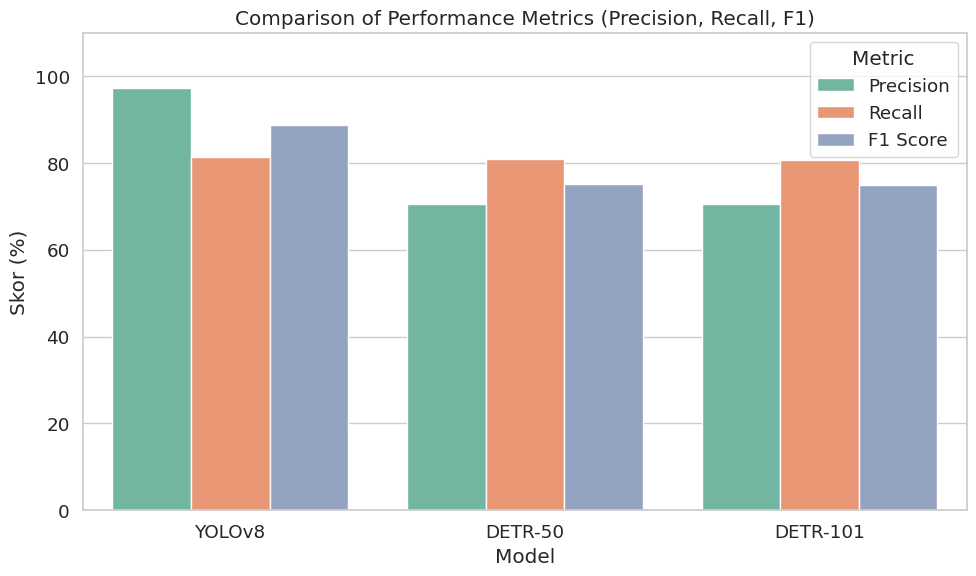

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stil ayarı
sns.set(style="whitegrid", font_scale=1.2)

# Melt işlemi
df_melted = df_scores.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Grafik çizimi
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="Set2")
plt.title("Comparison of Performance Metrics (Precision, Recall, F1)")
plt.ylabel("Skor (%)")
plt.ylim(0, 110)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("model_performance_plot_updated.png", dpi=300)
plt.show()
